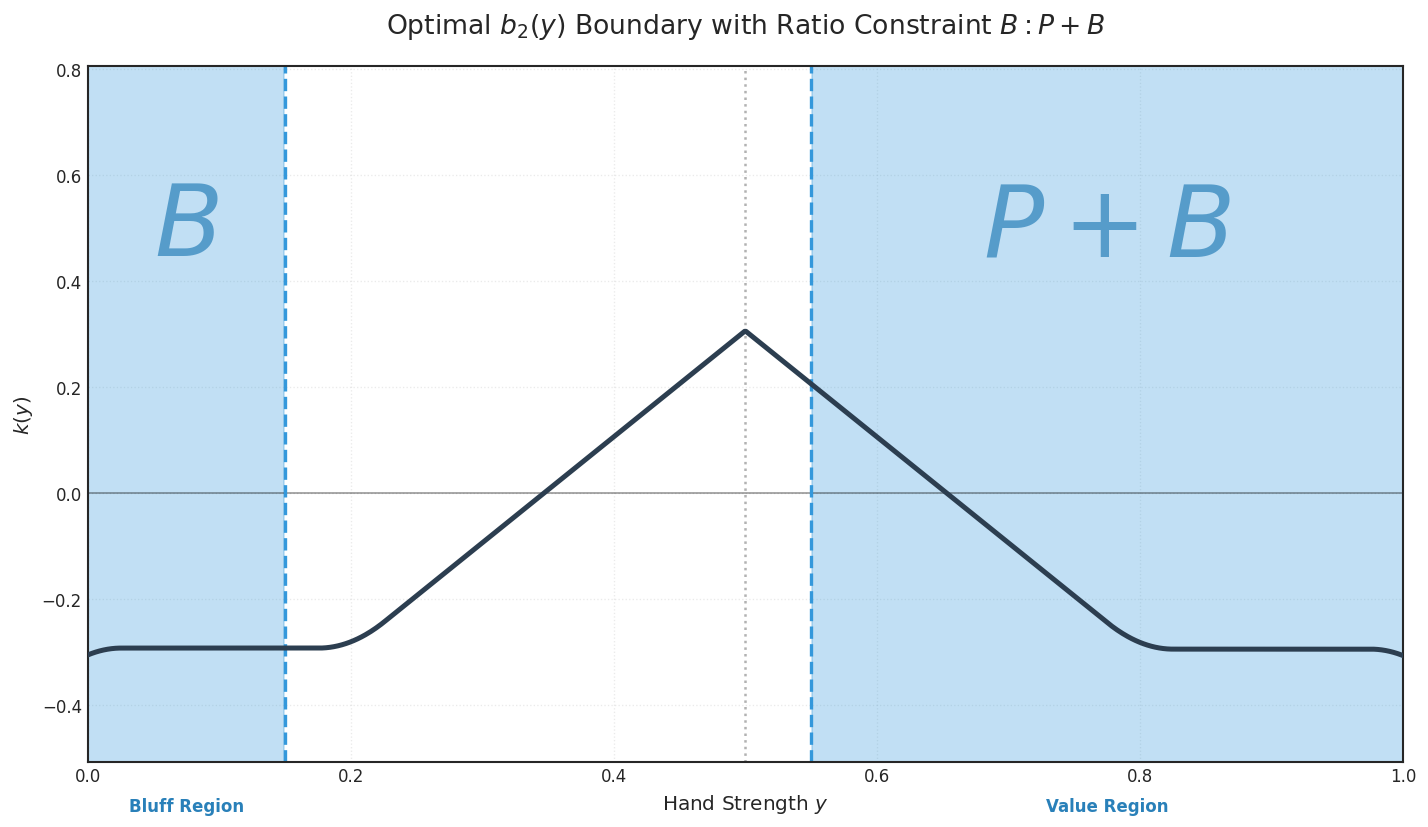

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 參數與比例設置
# ==========================================
P = 2.0  # 設定為整數
B = 1.0  # 設定為整數
lamda = 0.45  # 控制下注範圍縮放

# 確保 z1 : (1-z2) = B : P+B
ratio = B / (P + B)
z1 = lamda * ratio
z2 = 1 - lamda

# ==========================================
# 2. 數值模擬 (支援 a1 為數列)
# ==========================================
t = np.linspace(0, 1, 1000)
dt = t[1] - t[0]
x2_star = 0.5

# --- a1(x) 現在可以是任何數列 ---
# 這裡模擬一個極化的 a1(x)：強牌與弱牌下注，中間牌 Check
a1 = np.zeros_like(t)
a1[t < 0.2] = 1.0   # Bluff range
a1[t > 0.8] = 1.0   # Value range
# 平滑化處理 (可選)
a1 = np.convolve(a1, np.ones(50)/50, mode='same')

f_x = 1.0 - a1  # Player A Check 的密度

# 計算銜接點 k(x2*) = B * Integral_{x2*}^1 f(x) dx
k_at_x2 = B * np.sum(f_x[t >= x2_star]) * dt

# 根據微分方程構造 k(y)
k_y = np.zeros_like(t)

# 計算 k1 段 (0 到 0.5): k1'(y) = P * f(y)
# 使用 np.cumsum 來優化數列計算
k_y[:500] = k_at_x2 - P * np.flip(np.cumsum(np.flip(f_x[:500]))) * dt

# 計算 k2 段 (0.5 到 1.0): k2'(y) = -2B * f(y)
k_y[500:] = k_at_x2 - 2 * B * np.cumsum(f_x[500:]) * dt

# ==========================================
# 3. 繪圖
# ==========================================
fig, ax = plt.subplots(figsize=(12, 7), dpi=120)
plt.style.use('seaborn-v0_8-white')

# 畫出連續的 k(y)
ax.plot(t, k_y, color='#2c3e50', linewidth=3, label='$k(y)$', zorder=5)
ax.axhline(0, color='black', linewidth=1, alpha=0.4)
ax.axvline(x2_star, color='gray', linestyle=':', alpha=0.6)

# 填充 b2(y) 區域
blue_fill = '#3498db'
ax.fill_between(t, -2, 2, where=(t <= z1), color=blue_fill, alpha=0.3)
ax.fill_between(t, -2, 2, where=(t >= z2), color=blue_fill, alpha=0.3)
ax.axvline(z1, color=blue_fill, linestyle='--', linewidth=2)
ax.axvline(z2, color=blue_fill, linestyle='--', linewidth=2)

# ★★★ 標示大字體 B 與 P+B (Alpha=0.7, 整數) ★★★
# 標示 B
ax.text(z1 / 2, 0.5, f"$B$", 
        fontsize=60, ha='center', va='center', 
        color='#2980b9', fontweight='bold', alpha=0.7, zorder=10)

# 標示 P+B
ax.text(z2 + (1 - z2) / 2, 0.5, f"$P+B$", 
        fontsize=60, ha='center', va='center', 
        color='#2980b9', fontweight='bold', alpha=0.7, zorder=10)

# 輔助文字
ax.text(z1/2, -0.6, 'Bluff Region', color='#2980b9', ha='center', fontweight='bold')
ax.text(z2 + (1-z2)/2, -0.6, 'Value Region', color='#2980b9', ha='center', fontweight='bold')

# 設定標題與標籤
ax.set_title(r"Optimal $b_2(y)$ Boundary with Ratio Constraint $B : P+B$", fontsize=16, pad=20)
ax.set_xlim(0, 1)
ax.set_ylim(np.min(k_y) - 0.2, np.max(k_y) + 0.5)
ax.set_xlabel("Hand Strength $y$", fontsize=12)
ax.set_ylabel("$k(y)$", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

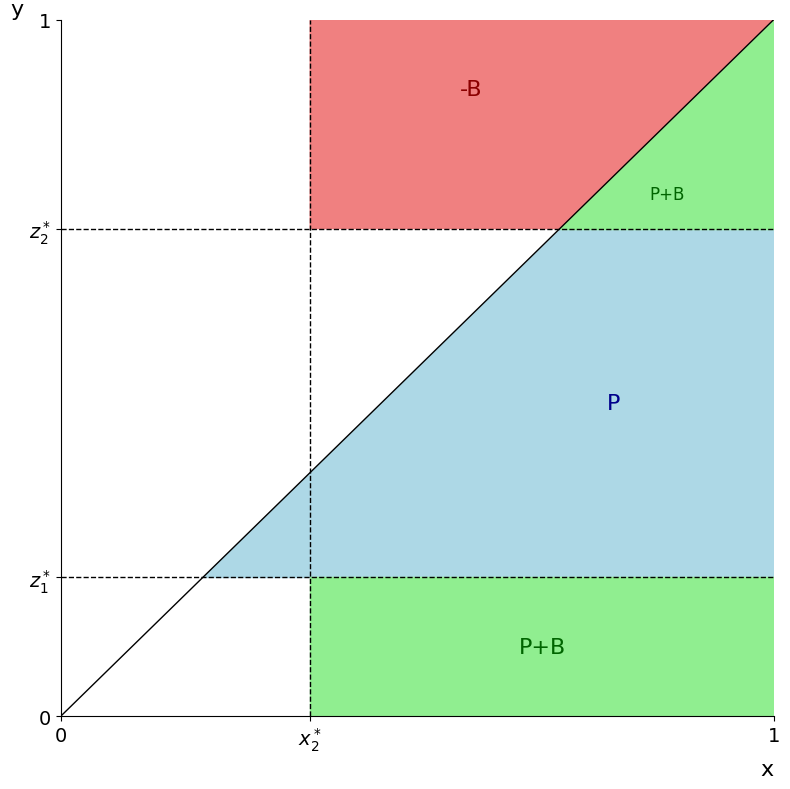

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os 

# === 1. 設定參數 ===
# 根據圖示邏輯設定相對位置： 0 < z1* < x2* < z2* < 1
Z1_STAR = 0.2
X2_STAR = 0.35
Z2_STAR = 0.7
XY_LIMIT = 1.0

# 建立畫布
fig, ax = plt.subplots(figsize=(8, 8))

# === 2. 定義顏色 ===
COLOR_MINUS_B = 'lightcoral'   # -B: 紅色系
COLOR_P = 'lightblue'          # P: 藍色系
COLOR_PB = 'lightgreen'        # P+B: 綠色系 (兩塊用同一色)

# === 3. 繪製區域 ===

# --- 區域 A: "-B" 區域 ---
# 條件: y > z2* (上方), x > x2* (右側), x < y (對角線上方)
# 形狀: 是一個被對角線切過的梯形/多邊形
# 頂點順序: (x2*, z2*) -> (z2*, z2*) -> (1, 1) -> (x2*, 1) -> 回到起點
ax.fill([X2_STAR, Z2_STAR, 1, X2_STAR], 
        [Z2_STAR, Z2_STAR, 1, 1],
        color=COLOR_MINUS_B, label='-B Region')
# 標籤
ax.text((X2_STAR + 1)/2 - 0.1, (Z2_STAR + 1)/2 + 0.05, '-B', 
        color='darkred', fontsize=16, ha='center', va='center')


# --- 區域 B: "P" 區域 ---
# 條件: z1* < y < z2* (中間), x > x2* (右側), x > y (對角線下方)
# 左邊界 logic: 在 y < x2* 的部分被 x=x2* 切，在 y > x2* 的部分被 y=x 切
# 頂點順序: (z1*, z1*) -> (1, z1*) -> (1, z2*) -> (z2*, z2*)  -> 回到起點
ax.fill([Z1_STAR, 1, 1, Z2_STAR], 
        [Z1_STAR, Z1_STAR, Z2_STAR, Z2_STAR],
        color=COLOR_P, label='P Region')
# 標籤
ax.text((X2_STAR + 1)/2 + 0.1, (Z1_STAR + Z2_STAR)/2, 'P', 
        color='darkblue', fontsize=16, ha='center', va='center')


# --- 區域 C1: 下方的 "P+B" 區域 ---
# 條件: y < z1* (下方), x > x2* (右側)
# 因為 z1* < x2*，所以在此區域恆有 x > y (對角線下方)
ax.fill([X2_STAR, 1, 1, X2_STAR], 
        [0, 0, Z1_STAR, Z1_STAR],
        color=COLOR_PB, label='P+B Region')
# 標籤
ax.text((X2_STAR + 1)/2, Z1_STAR/2, 'P+B', 
        color='darkgreen', fontsize=16, ha='center', va='center')


# --- 區域 C2: 右上角的 "P+B" 區域 (新增的部分) ---
# 條件: y > z2* (上方), x > y (對角線下方)
# 形狀: 三角形
ax.fill([Z2_STAR, 1, 1], 
        [Z2_STAR, Z2_STAR, 1],
        color=COLOR_PB) # 同色，不重複 label
# 標籤 (空間較小，字縮小一點)
ax.text(Z2_STAR + 0.15, Z2_STAR + 0.05, 'P+B', 
        color='darkgreen', fontsize=12, ha='center', va='center')


# === 4. 輔助線與裝飾 ===

# 畫對角線 y=x
ax.plot([0, 1], [0, 1], 'k-', linewidth=1)

# 畫閾值線 (虛線)
ax.axvline(x=X2_STAR, color='k', linestyle='--', linewidth=1)
ax.axhline(y=Z1_STAR, color='k', linestyle='--', linewidth=1)
ax.axhline(y=Z2_STAR, color='k', linestyle='--', linewidth=1)

# 座標軸設定
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 刻度標籤
ax.set_xticks([0, X2_STAR, 1])
ax.set_xticklabels(['0', r'$x_2^*$', '1'], fontsize=14)
ax.set_yticks([0, Z1_STAR, Z2_STAR, 1])
ax.set_yticklabels(['0', r'$z_1^*$', r'$z_2^*$', '1'], fontsize=14)

# 軸名稱
ax.set_xlabel('x', fontsize=16, loc='right')
ax.set_ylabel('y', fontsize=16, loc='top', rotation=0)

plt.tight_layout()
os.makedirs('images/lesson_7', exist_ok=True)
plt.savefig('images/lesson_7/integral_region_Jxy.png', dpi=300, bbox_inches='tight')
plt.show()